# Logistic Regression with a Single Neuron
In this notebook, we implement **Logistic Regression** using a custom-built **SingleNeuron** class.

Logistic regression is a classification algorithm used to predict the **probability** that a given input belongs to a specific class.
Instead of producing continuous values like linear regression, it produces a value between 0 and 1 by passing the result of a linear equation through the **sigmoid function**:
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

This value can be interpreted as a probability, and we assign class labels (0 or 1) based on a threshold (commonly 0.5).

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from mlxtend.plotting import plot_decision_regions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

##  Load and Preprocess the Hearts Dataset
We will use the `hearts` dataset and classify a patient as either **Has Heart Disease**(label=1) or **Does not have Heart Disease**(label=0)

We'll also drop any rows with missing values.

## Normalize and Prepare Features
Logistic regression works best when the input features are on a similar scale. We'll normalize the features to have mean 0 and standard deviation 1.

In [ ]:
# Load and process the heart dataset 
data = pd.read_csv("/Users/kene_2x/Desktop/CMOR 438: DS and Machine Learning/Untitled/Kene_CMOR_438_Spring_25/data/heart.csv")
hearts = data.copy(deep = True)

le = LabelEncoder()#Label Encoding

#Label Encode all Categorical data
hearts['Sex'] = le.fit_transform(hearts['Sex'])
hearts['ChestPainType'] = le.fit_transform(hearts['ChestPainType'])
hearts['RestingECG'] = le.fit_transform(hearts['RestingECG'])
hearts['ExerciseAngina'] = le.fit_transform(hearts['ExerciseAngina'])
hearts['ST_Slope'] = le.fit_transform(hearts['ST_Slope'])

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

#Normalize Oldpeak and Standardize the rest of the numerical data
hearts['Oldpeak'] = mms.fit_transform(hearts[['Oldpeak']])
hearts['Age'] = ss.fit_transform(hearts[['Age']])
hearts['RestingBP'] = ss.fit_transform(hearts[['RestingBP']])
hearts['Cholesterol'] = ss.fit_transform(hearts[['Cholesterol']])
hearts['MaxHR'] = ss.fit_transform(hearts[['MaxHR']])
hearts.head

<bound method NDFrame.head of           Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.433140    1              1   0.410909     0.825070          0   
1   -0.478484    0              2   1.491752    -0.171961          0   
2   -1.751359    1              1  -0.129513     0.770188          0   
3   -0.584556    0              0   0.302825     0.139040          0   
4    0.051881    1              2   0.951331    -0.034755          0   
..        ...  ...            ...        ...          ...        ...   
913 -0.902775    1              3  -1.210356     0.596393          0   
914  1.536902    1              0   0.627078    -0.053049          1   
915  0.370100    1              0  -0.129513    -0.620168          0   
916  0.370100    0              1  -0.129513     0.340275          0   
917 -1.645286    1              2   0.302825    -0.217696          0   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0             1  1.382928  

# Features Selection
To better understand why we selected these specific features for classification, read the **Perceptron_hearts** file.

We'll select the "Age", "Oldpeak", "MaxHR", "ST_Slope", "ExerciseAngina", "Sex","ChestPainType","Cholesterol", and "FastingBS" for classification.


In [3]:
features = [
    "Age", "Oldpeak", "MaxHR", "ST_Slope", "ExerciseAngina", "Sex", "HeartDisease","ChestPainType","Cholesterol","FastingBS"
]
filtered_df= hearts[features].reset_index(drop=True)
X = filtered_df[filtered_df.columns.drop(['HeartDisease'])].values
y = filtered_df['HeartDisease'].values

## Split Dataset into Training and Testing Sets
This cell splits the dataset into training and testing subsets using an 80/20 split.

In [7]:
#Split data into test and trainung data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define Sigmoid Function and Cross-Entropy Loss
The **sigmoid function** squashes input values between 0 and 1, making it perfect for binary classification.

The **cross-entropy loss** function measures how far off a prediction is from the true label. It's commonly used for classification tasks.

In [8]:
def sigmoid(z):
	return 1.0 / (1.0 + np.exp(-z))

def cross_entropy(y_hat, y):
	return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

## Build and Train the SingleNeuron Class
We now use a single neuron with sigmoid activation and cross-entropy loss to learn the classification boundary.

In [9]:
class SingleNeuron(object):
	def __init__(self, activation_function, cost_function):
		self.activation_function = activation_function
		self.cost_function = cost_function

	def train(self, X, y, alpha = 0.005, epochs = 50):
		self.w_ = np.random.rand(1 + X.shape[1])
		self.errors_ = []
		N = X.shape[0]

		for _ in range(epochs):
			errors = 0
			for xi, target in zip(X, y):
				error = (self.predict(xi) - target)
				self.w_[:-1] -= alpha*error*xi
				self.w_[-1] -= alpha*error
				errors += self.cost_function(self.predict(xi), target)
			self.errors_.append(errors/N)
		return self

	def predict(self, X):
		preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
		return self.activation_function(preactivation)

## Train the Model

In [10]:
# Set the Seaborn theme
sns.set_theme()

# Instantiate and train the logistic regression model
neuron = SingleNeuron(activation_function=sigmoid, cost_function=cross_entropy)
neuron.train(X_train, y_train, epochs=1000)

## Plot Training Loss Over Time

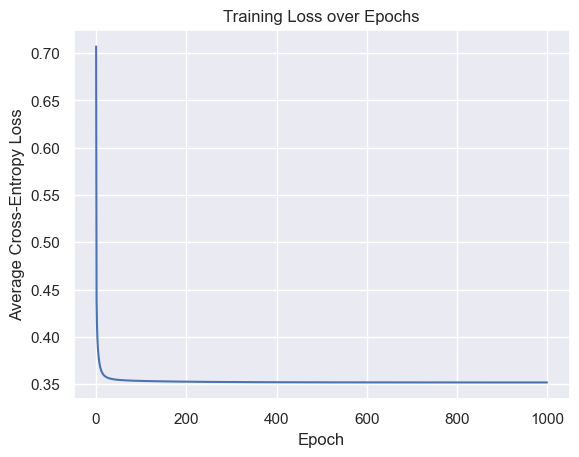

In [11]:
plt.plot(neuron.errors_)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Cross-Entropy Loss')
plt.grid(True)
plt.show()

## Evaluate Model Performance

In [14]:
y_hat = np.where(neuron.predict(X_test) >= 0.5, 1, 0)
np.rint(y_hat) != y_test
classification_error = (np.rint(y_hat) != y_test).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y_test)}")

Classification Error = 0.15760869565217392


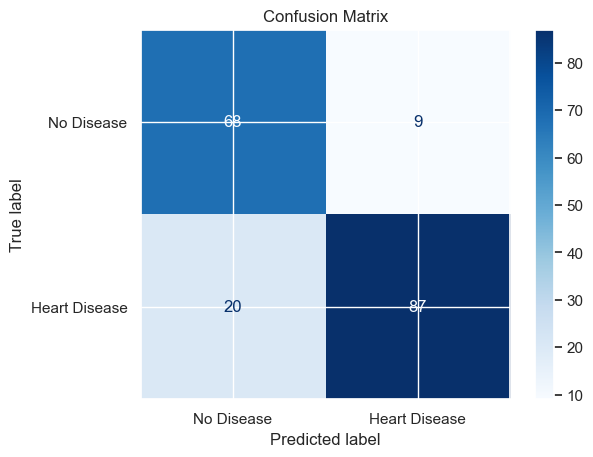

Classification Report:

               precision    recall  f1-score   support

   No Disease       0.77      0.88      0.82        77
Heart Disease       0.91      0.81      0.86       107

     accuracy                           0.84       184
    macro avg       0.84      0.85      0.84       184
 weighted avg       0.85      0.84      0.84       184



In [18]:
# Ensure labels are binary: 0 and 1
y_true_binary = np.where(y_test == -1, 0, y_test) if -1 in y_test else y_test
y_pred_binary = np.where(y_hat == -1, 0, y_hat) if -1 in y_hat else y_hat

# Compute confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Heart Disease"])

# Plot
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



# Ensure ground truth is 0/1
y_true_binary = np.where(y_test == -1, 0, y_test)

# Convert predicted probabilities to binary labels
y_pred_binary = (y_hat >= 0.5).astype(int)

# Generate classification report
report = classification_report(y_true_binary, y_pred_binary, target_names=["No Disease", "Heart Disease"])

# Print the report
print("Classification Report:\n")
print(report)


As we can see, our implementation has an accuracy of about 84% and the training loss over epochs goes down to a minimum of about 0.35. Our classification is mostly accurate.

## Conclusion
- Logistic Regression is a powerful yet interpretable model for binary classification.
- The model converged well and made mostly accurate predictions determining if a patient had or didnt have heart disease.
- We trained it from scratch using gradient descent and monitored its learning using cross-entropy loss.